In [ ]:
import pandas as pd
from safeaipackage import core

from src.load_data import load_predictions

In [ ]:
MODEL_ORDER = [
    "Nowcast",
    "Ensemble",
    "LightGBM",
    "LightGBM-NoCovariates",
    "LightGBM-NoCovid",
    "LightGBM-Oracle",
    "LightGBM-Skip",
    "LightGBM-Uncorrected",
    "TSMixer",
    "TSMixer-NoCovariates",
    "TSMixer-NoCovid",
    "TSMixer-Oracle",
    "TSMixer-Skip",
    "TSMixer-Uncorrected",
    "hhh4",
    "hhh4-NoCovid",
    "hhh4-Oracle",
    "hhh4-Skip",
    "hhh4-Uncorrected",
    "Persistence",
    "Historical",
]

MAIN_MODELS = ["Ensemble", "LightGBM", "TSMixer", "hhh4", "Historical", "Persistence"]

In [ ]:
df = load_predictions()
df = df[df.model.isin(MAIN_MODELS)].copy()
model_order = [m for m in MODEL_ORDER if m in df.model.unique()]
df["model"] = pd.Categorical(df["model"], categories=model_order, ordered=True)
df = df[df.age_group == "00+"]
df = df[df["type"] == "median"]

# Compute RGA for each model and horizon
results = []
for h in [1, 2, 3, 4]:
    df_h = df[df.horizon == h]
    for m in df_h.model.unique():
        df_temp = df_h[df_h.model == m]
        score = core.rga(df_temp.value, df_temp.truth)
        results.append({"model": m, "horizon": h, "rga": score})

df_results = pd.DataFrame(results)
df_results["model"] = pd.Categorical(
    df_results["model"], categories=model_order, ordered=True
)
df_results = df_results.sort_values(by=["horizon", "model"]).reset_index(drop=True)

df_wide = df_results.pivot(index="model", columns="horizon", values="rga")
df_wide.columns = [f"horizon_{h}" for h in df_wide.columns]
df_wide = df_wide.reset_index()

In [5]:
df_wide

,model,horizon_1,horizon_2,horizon_3,horizon_4
0,Ensemble,0.970489,0.958142,0.955261,0.948775
1,LightGBM,0.967930,0.954156,0.943352,0.922535
2,TSMixer,0.957024,0.942332,0.940735,0.937109
3,hhh4,0.971026,0.954822,0.947454,0.943053
4,Persistence,0.965391,0.937694,0.909435,0.882583
5,Historical,0.954336,0.957344,0.959226,0.963196


In [ ]:
# Generate LaTeX table code
latex_table = df_wide.to_latex(
    float_format="%.3f",  # format floats to 3 decimal places
    caption="RGA scores by model and forecast horizon",
    label="tab:rga_scores",
    column_format="lcccc",
    escape=False,
)

# Print the LaTeX code
print(latex_table)

\begin{table}
\caption{RGA scores by model and forecast horizon}
\label{tab:rga_scores}
\begin{tabular}{lcccc}
\toprule
 & model & horizon_1 & horizon_2 & horizon_3 & horizon_4 \\
\midrule
0 & Ensemble & 0.970 & 0.958 & 0.955 & 0.949 \\
1 & LightGBM & 0.968 & 0.954 & 0.943 & 0.923 \\
2 & TSMixer & 0.957 & 0.942 & 0.941 & 0.937 \\
3 & hhh4 & 0.971 & 0.955 & 0.947 & 0.943 \\
4 & Persistence & 0.965 & 0.938 & 0.909 & 0.883 \\
5 & Historical & 0.954 & 0.957 & 0.959 & 0.963 \\
\bottomrule
\end{tabular}
\end{table}



# Example

In [ ]:
d = pd.DataFrame(
    {
        "x": [1, 2, 3, 4],
        "truth": [4, 9, 10, 1],
        "y1": [3, 10, 9, 2],
        "y2": [21, 22, 30, 17],
    }
)

RGA of y1: 0.9666666666666667
RGA of y2: 1.0


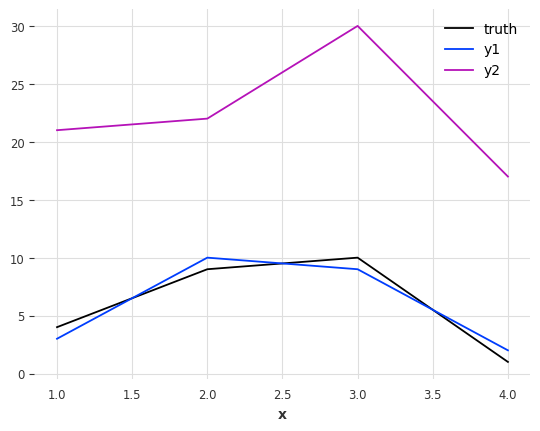

In [ ]:
d.set_index("x").plot()
for y in ["y1", "y2"]:
    score = core.rga(d[y], d.truth)
    print(f"RGA of {y}: {score}")